In [161]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [162]:
import numpy as np
import pandas as pd

In [119]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [84]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [85]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [86]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [87]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [88]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [89]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [90]:
# determine the columns for each table in database

# first, get the measurement columns
measurement_example = session.query(Measurement).first()
print(measurement_example.__dict__)

# next, get the station columns
station_example = session.query(Station).first()
print(station_example.__dict__)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000002A086C37808>, 'prcp': 0.08, 'id': 1, 'station': 'USC00519397', 'date': '2010-01-01', 'tobs': 65.0}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000002A087C59808>, 'name': 'WAIKIKI 717.2, HI US', 'longitude': -157.8168, 'id': 1, 'latitude': 21.2716, 'station': 'USC00519397', 'elevation': 3.0}


('2017-08-23',)
The date one year before the final date is 2016-08-23 according the results of the query.


,prcp
date,
2016-08-23,1.79
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18
...,...
2017-08-19,0.09
2017-08-20,0.01
2017-08-21,0.56


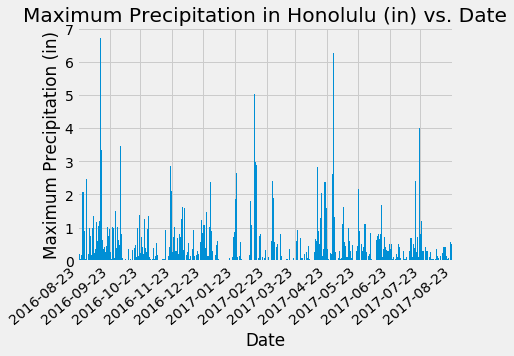

In [234]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
final_date = session.query(Measurement.date).order_by(Measurement.date.desc())[0]
print(final_date)
print("The date one year before the final date is 2016-08-23 according the results of the query.")

# Perform a query to retrieve the data and precipitation scores
last_year_precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23').all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Since there are 2230 values and only 365 dates, we need to aggregate the precipitation
# values to a measure of center, so we will drop all null values and then get the 
# average precipitation for each date, since it is usually measured by multiple stations

# store in a dataframe
last_year_precipitation_df = pd.DataFrame(last_year_precipitation)

# clean data by dropping null values
last_year_precipitation_df = last_year_precipitation_df.dropna()

# now change the "date" column to the dateteme data type 
last_year_precipitation_df.date = pd.to_datetime(last_year_precipitation_df.date)

# then group by the date and get the maximum value, which also sets the "date"
# column to the index
max_precipitation_df = last_year_precipitation_df.groupby("date").max()

# Sort the dataframe by date - should already be sorted, but just double-check
max_precipitation_df = max_precipitation_df.sort_values(by = "date")


# Use Pandas Plotting with Matplotlib to plot the data
# max_precipitation_df_plot = max_precipitation_df.copy()
# max_precipitation_df_plot.index = mdates.date2num(max_precipitation_df_plot.index)
# print(max_precipitation_df_plot)
#first, try to get months index value and put them in the x-ticks list
month_index_values = []
month_values = []
for i, date in enumerate(max_precipitation_df.index):
    if(date.day == max_precipitation_df.index[0].day):
        month_index_values.append(i)
        month_values.append(date)
        
#copy of month_values to be used for the tick locations after the first list is expended for the xtick labels
month_values2 = month_values[:]

precip_axes = max_precipitation_df.plot(kind="bar", y="prcp", width=1, title="Maximum Precipitation in Honolulu (in) vs. Date", legend=False)

precip_axes.xaxis.minorTicks = precip_axes.xaxis.majorTicks
precip_axes.set_xticklabels([month_values.pop(0).strftime("%Y-%m-%d") for i in range(len(avg_precipitation_df.index)) if(i in month_index_values)],
                            rotation=40, ha="right")


# print(plt.axis()) - used to determine the units for the x-axis, since datetime could not be compared to float!
precip_axes.set_xticks([(month_values2.pop(0)-max_precipitation_df.index[0]).days for i in range(len(max_precipitation_df.index)) if(i in month_index_values)])
precip_axes.set_xlabel("Date")
precip_axes.set_ylabel("Maximum Precipitation (in)")

max_precipitation_df

In [156]:
# Use Pandas to calculate the summary statistics for the precipitation data
max_precipitation_df.describe()

,prcp
count,366.000000
mean,0.520765
std,0.830728
min,0.000000
25%,0.040000
50%,0.250000
75%,0.672500
max,6.700000


In [ ]:
# Design a query to show how many stations are available in this dataset?


In [ ]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
